In [2]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from ibllib.atlas import AllenAtlas
from brainbox.core import TimeSeries
from brainbox.processing import bin_spikes

import numpy as np
import pandas as pd
import random

## EDA

In [5]:
pw = 'international'
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password=pw, silent=True)
ba = AllenAtlas()
pid = '73ff4936-8cd3-4a75-a772-f563e67d249d'
eid = one.pid2eid(pid)[0]

'ebe2efe3-e8a1-451a-8947-76ef42427cc9'

In [6]:
sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)
trials = one.load_object(eid, 'trials', collection='alf')

C:\Users\asing\Downloads\ONE\openalyx.internationalbrainlab.org\angelakilab\Subjects\NYU-21\2020-08-19\001\alf\_ibl_trials.stimOff_times.npy: 100%|██████████| 5.50k/5.50k [00:00<00:00, 29.6kB/s]
C:\Users\asing\Downloads\ONE\openalyx.internationalbrainlab.org\angelakilab\Subjects\NYU-21\2020-08-19\001\alf\_ibl_trials.table.pqt: 100%|██████████| 54.3k/54.3k [00:00<00:00, 201kB/s]
C:\Users\asing\Downloads\ONE\openalyx.internationalbrainlab.org\angelakilab\Subjects\NYU-21\2020-08-19\001\alf\_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.50k/5.50k [00:00<00:00, 29.5kB/s]


In [ ]:
spikes

{'depths': array([2800.25170898, 3361.30664062, 2904.30395508, ..., 2028.19030762,
        3678.875     , 3317.64160156]),
 'clusters': array([155, 245, 392, ..., 105, 330, 232], dtype=uint32),
 'amps': array([5.56051677e-05, 1.42381795e-04, 5.43605668e-05, ...,
        8.33171788e-05, 3.97071509e-05, 9.17442225e-05]),
 'times': array([1.66376258e-02, 1.72376258e-02, 1.87042924e-02, ...,
        6.55829322e+03, 6.55829669e+03, 6.55830292e+03])}

In [7]:
# the channels are the physicals probes of the neuropixels. There are 384 probes, hence 384 channels
channels['x'].shape

(384,)

In [8]:
spikes['clusters'][spikes['clusters']==4].shape

(5494,)

In [9]:
spikes['times'].max()

6558.302919443709

In [10]:
spikes.keys()

dict_keys(['depths', 'clusters', 'amps', 'times'])

In [11]:
clusters.keys()

dict_keys(['uuids', 'channels', 'depths', 'cluster_id', 'amp_max', 'amp_min', 'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt', 'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio', 'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate', 'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um'])

In [12]:
for i in clusters:
    print(i, ": ", clusters[i][-105:])

uuids :  383    00634996-716b-4010-9b6c-de6a1eec38b8
384    0ac63ce5-c849-4f72-8535-f646e3b14827
385    51c5ac26-e5d1-48e7-a739-51f182df86f2
386    2c9d476b-5f32-4271-a65f-b6167a4b18aa
387    f1102729-02ed-4d74-9150-63f336509088
                       ...                 
483    e2b5a670-64b6-42f6-93b4-d9c42552ee89
484    b2eb692d-d583-4077-9a1e-c80ff4bf307f
485    e534b8d9-e82a-4ec0-8760-1fe7f35fffb4
486    9803e17b-0bd8-4980-a5ca-d5f4d3df5325
487    7f376dcc-acac-4286-aeca-a822070f7fb0
Name: uuids, Length: 105, dtype: object
channels :  [244 250 250 259 266 270 271 281 281 291 294 295 295 304 305 309 305 308
 310 313 325 321 321 321 325 327 327 331 333 334 338 337 337 338 338 343
 344 344 345 345 345 346 346 346 345 350 352 352 352 354 356 356 357 358
 358 358 360 361 361 360 363 365 361 365 367 367 367 369 369 367 370  34
 244 242 246 266 270 270 294 295 305 305 305 305 316 325 317 333 338 345
 358 358 363 363 365 367  34 244 295 305 321 321 333 363 333]
depths :  [2460. 2520. 2520.

In [13]:
trials.keys()

dict_keys(['goCueTrigger_times', 'stimOff_times', 'response_times', 'feedbackType', 'stimOn_times', 'contrastLeft', 'goCue_times', 'feedback_times', 'rewardVolume', 'contrastRight', 'firstMovement_times', 'choice', 'probabilityLeft', 'intervals'])

(<Figure size 1600x900 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-12-03_1_ZFM-01576_probe00, 6eb8be8d-d089-43c6-b2e4-a6558ca16dcf \n6_821_862 spikes, 488 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

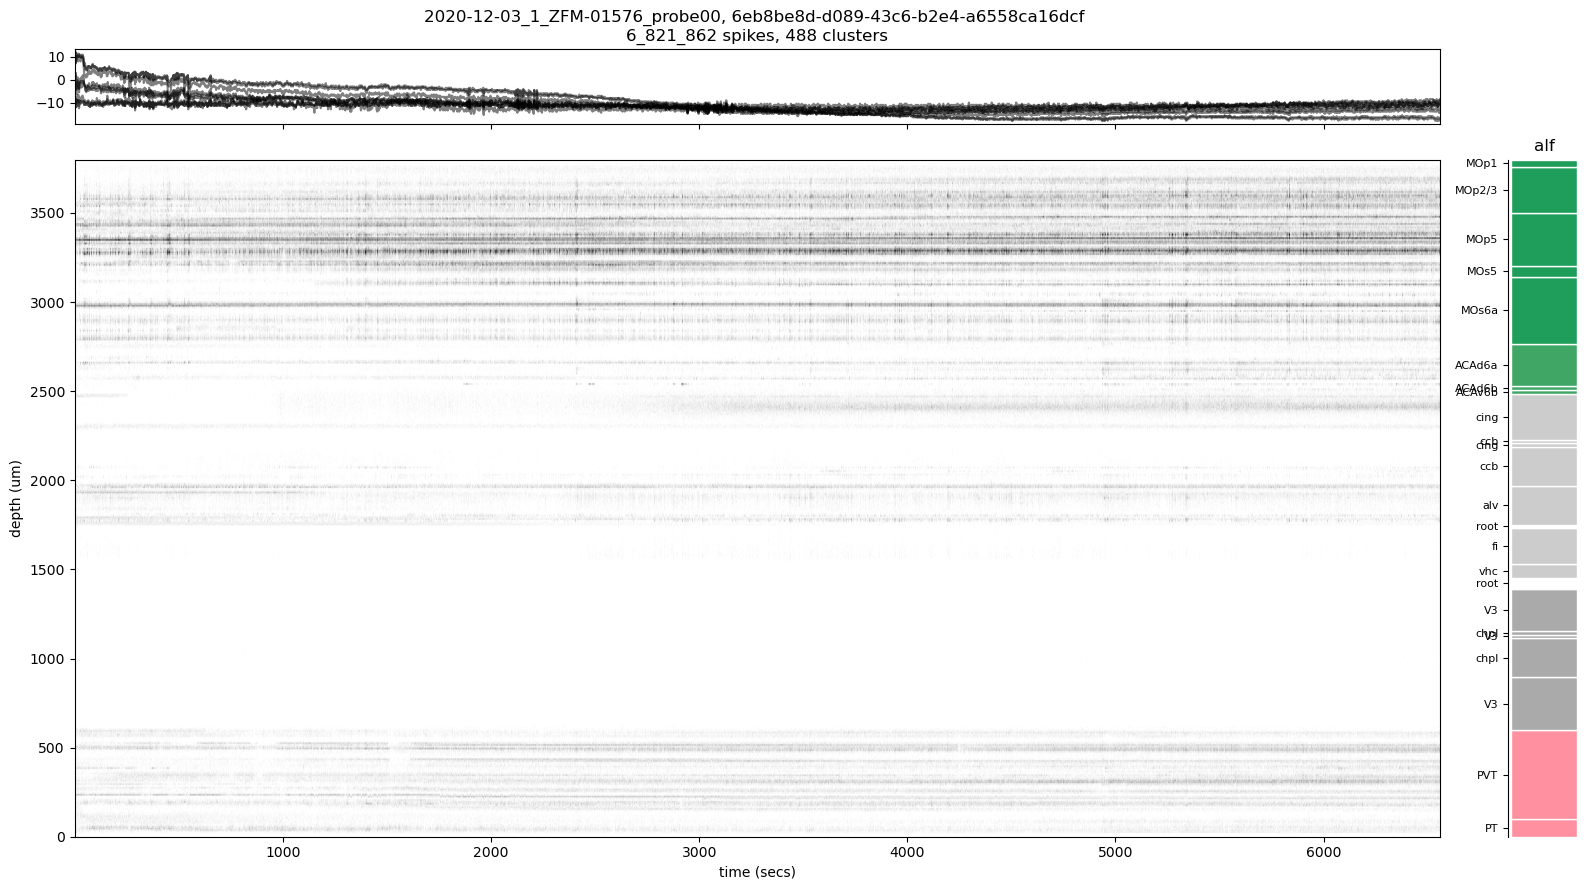

In [14]:
sl.raster(spikes, channels)

### Data Cleaning
1) Filter data for only good clusters (should indicate single neurons), and for brain regions MOp and MOs
2) Group spikes by neurons
3) Split data across trials
4) Bin spike times for each neuron, for each trial

In [66]:
# good_clusterIDs = clusters['cluster_id'][((clusters['label'] == 1) & ([True if "MO" in s else False for s in clusters['acronym']]))] # Find good clusters that are in MOp and MOs
# good_clusterIDs = clusters['cluster_id'][clusters['label'] == 1] # Find good clusters that are in MOp and MOs
good_clusterIDs = clusters['cluster_id'][[True if "MO" in s else False for s in clusters['acronym']]] # Find good clusters that are in MOp and MOs
good_cluster_loc = np.isin(spikes['clusters'], good_clusterIDs)

In [67]:
good_spikes = {}
for i in spikes:
    good_spikes[i] = spikes[i][good_cluster_loc]

In [17]:
good_spikes

{'depths': array([3361.30664062, 2904.30395508, 3339.80297852, ..., 3219.14282227,
        3339.73730469, 3601.29882812]),
 'clusters': array([245, 392, 237, ..., 211, 237, 302], dtype=uint32),
 'amps': array([1.42381795e-04, 5.43605668e-05, 2.33703407e-04, ...,
        2.80053150e-04, 3.18973675e-04, 1.10413923e-04]),
 'times': array([1.72376258e-02, 1.87042924e-02, 2.07709589e-02, ...,
        6.55828192e+03, 6.55828195e+03, 6.55829135e+03])}

In [18]:
channels.keys()

dict_keys(['x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um'])

(<Figure size 1600x900 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-12-03_1_ZFM-01576_probe00, 6eb8be8d-d089-43c6-b2e4-a6558ca16dcf \n1_280_696 spikes, 40 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

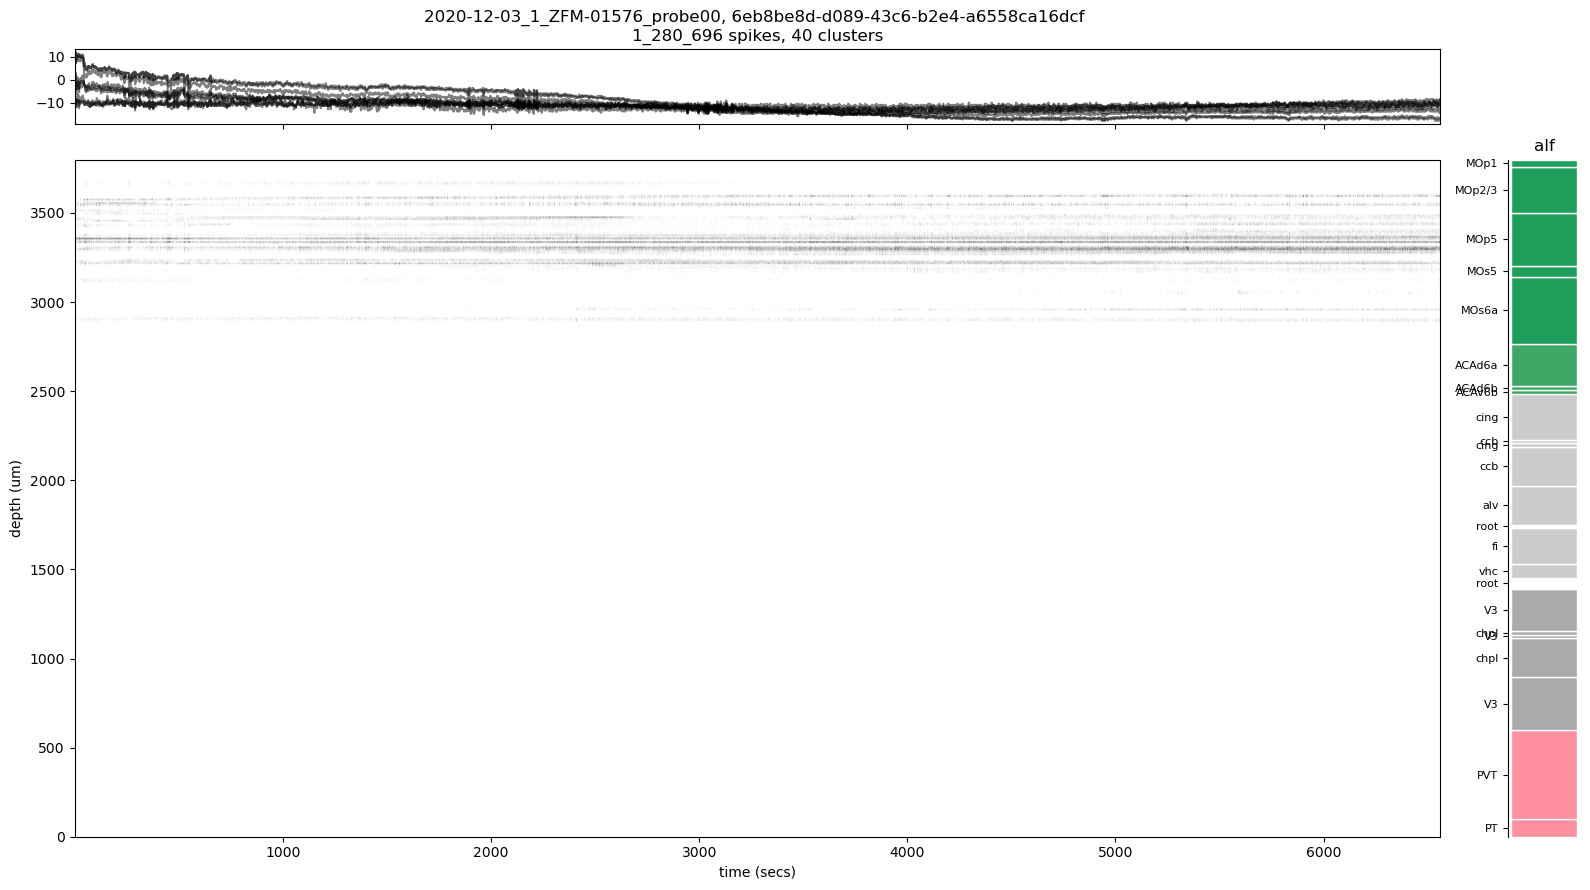

In [19]:
sl.raster(good_spikes, channels)

In [20]:
np.unique(trials['choice'])

array([-1.,  1.])

In [21]:
np.unique(trials['feedbackType'])

array([-1.,  1.])

In [68]:
bin_size = 50e-3 # in milliseconds
# min_bins = max(int((60e-3 / bin_size)), 20)
max_trial_type = 40 # Maximum number of trials of each trial type

In [69]:
# good_spikes
# All trials must have the same number of neurons
df = pd.DataFrame(data = {'clusters':good_spikes['clusters'], 'times':good_spikes['times']})
df = df.groupby('clusters')['times'].apply(np.array)

Implementation with bins as a fixed size:

In [24]:
# trials_spikes = [] # The Spike times and results of each trial

# for i in range(len(trials['goCueTrigger_times'])):
#     spike_range = {}
    
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     x = []
#     try:
#         hist_bins = np.arange(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i], bin_size)
#     except:
#         continue
#         # the hist bins throw an error if the go cute or first movement time is NaN
#         # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
#     if len(hist_bins) <= min_bins: # Mouse must have a minimum reaction time of 60 ms to be considered a good trial
#         continue
    
#     for j in df: # Iterate through spike times of each cluster
#         inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
#         # print(np.histogram(j[inds], hist_bins)[0])
#         x.append(np.histogram(j[inds], hist_bins)[0])
    
#     spikes_df = pd.DataFrame(x, index=df.index)
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

Implementation with a set number of bins instead of bin size:

In [25]:
# trials_spikes = [] # The Spike times and results of each trial

# for i in range(len(trials['goCueTrigger_times'])):
#     spike_range = {}
    
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     x = []
    
#     time_range = (trials['firstMovement_times'][i] - trials['goCue_times'][i])
#     if ((time_range < 0.10) | (time_range > 0.300)): # Mouse must have a minimum reaction time of 60 ms to be considered a good trial. We also exlude trials longer than 300 ms because they will have too many spikes per bin
#         continue
    
#     for j in df: # Iterate through spike times of each cluster
#         inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
#         # print(np.histogram(j[inds], hist_bins)[0])
#         x.append(np.histogram(j[inds], 200)[0]) # 200 bins
    
#     spikes_df = pd.DataFrame(x, index=df.index)
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

Implementation with bins starting 100ms before first movement to 300 ms after first movement

In [70]:
trials_spikes = [] # The Spike times and results of each trial

for i in range(len(trials['goCueTrigger_times'])):
    if (trials['firstMovement_times'][i] < trials['goCue_times'][i]+0.05):
        continue
    
    spike_range = {}
    
    spike_range['goCue_times'] = trials['goCue_times'][i]
    spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
    spike_range['choice'] = trials['choice'][i]
    spike_range['feedbackType'] = trials['feedbackType'][i]
    
    x = []
    try:
        hist_bins = np.arange(trials['firstMovement_times'][i]-0.1, trials['firstMovement_times'][i]+1.00001, bin_size)
        # print(len(hist_bins))
    except:
        continue
        # the hist bins throw an error if the go cue or first movement time is NaN
        # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
    
    for j in df: # Iterate through spike times of each cluster
        inds = ((j>(trials['firstMovement_times'][i]-0.1)) & (j<=(trials['firstMovement_times'][i]+1.00001))) # From go queue to first movement
        # print(np.histogram(j[inds], hist_bins)[0])
        x.append(np.histogram(j[inds], hist_bins)[0])
    
    spikes_df = pd.DataFrame(x, index=df.index)
    spike_range['spikes_df'] = spikes_df
    
    trials_spikes.append(spike_range)

In [27]:
random.shuffle(trials_spikes) # Randomize list before splitting into training and testing data

In [163]:
len(trials_spikes)

1007

In [71]:
training_trials = []
testing_trials = []


trial_counts = {"correct_left" : [0, 0],  # [training count, testing count]
                "correct_right" : [0, 0],
                "incorrect_left" : [0, 0], # incorrect left means that the mouse chose left, and it was incorrect
                "incorrect_right": [0, 0]}

for i in trials_spikes:
    if ((i["choice"]==-1) & (i["feedbackType"]==1)):
        if trial_counts['correct_left'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['correct_left'][0] += 1
        elif trial_counts['correct_left'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['correct_left'][1] += 1
        else:
            continue
    elif ((i["choice"]==1) & (i["feedbackType"]==1)):
        if trial_counts['correct_right'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['correct_right'][0] += 1
        elif trial_counts['correct_right'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['correct_right'][1] += 1
        else:
            continue
    elif ((i["choice"]==-1) & (i["feedbackType"]==-1)):
        if trial_counts['incorrect_left'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['incorrect_left'][0] += 1
        elif trial_counts['incorrect_left'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['incorrect_left'][1] += 1
        else:
            continue
    elif ((i["choice"]==1) & (i["feedbackType"]==-1)):
        if trial_counts['incorrect_right'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['incorrect_right'][0] += 1
        elif trial_counts['incorrect_right'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['incorrect_right'][1] += 1
        else:
            continue

In [165]:
len(training_trials)

227

In [166]:
# training_trials[0]["spikes_df"]

In [167]:
# trials_spikes = [] # The Spike times and results of each trial

# for i, interval in enumerate(trials['intervals']):
#     time_range = ((good_spikes['times']>interval[0]) & (good_spikes['times']<interval[1])) #Find the spikes corresponding to the current interval
#     spike_range = {}
    
#     for key in good_spikes:
#         spike_range[key] = good_spikes[key][time_range]
        
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
    
#     # Bin Spikes based on time= 0.1 seconds, per cluster
#     df = pd.DataFrame(data={'clusters':spike_range['clusters'], 'times':spike_range['times']})
#     hist_bins = np.arange(interval[0], interval[1], 0.1)
#     df = df.groupby('clusters')['times'].apply(list)
    
#     hist_rows = []
#     for i in df.iloc:
#         hist_rows.append(np.histogram(i, hist_bins)[0])
#     spikes_df = pd.DataFrame(hist_rows, columns=hist_bins[:-1], index=df.index) # Clusters are assumed to be good neurons
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

In [168]:
# sl.raster(trials_spikes[3], channels)

In [37]:
import math

import jax.random
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from vlgpax.model import Session
from vlgpax.kernel import RBF, RFF
from vlgpax import vi

In [72]:
training_trials[4]['spikes_df'].T

clusters,145,146,147,148,149,150,151,152,153,154,...,265,266,267,268,269,270,271,272,273,285
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,2,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,2,...,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,2,0,0,0,...,0,0,2,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,1,0,0


In [73]:
session = Session(bin_size)
# y = pd.read_csv("neural_data.csv")
# session.add_trial(0, y=y)
for i, trial in enumerate(training_trials):
    # print(trial['spikes_df'].T.shape)
    session.add_trial(i, y=trial['spikes_df'].T)

In [74]:
length_scale = 0.005# in seconds
kernel = RBF(scale=1, lengthscale=0.200)

In [75]:
session, params = vi.fit(session, n_factors=2, kernel=kernel, seed=10, max_iter=15, trial_length=20, GPFA=True)

Initializing
Initialized


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:270: UserWarning:

M: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



EM Iteration 1, 	Loss = 33.6644, 	M step: 3.41s, 	E step: 9.63s
EM Iteration 2, 	Loss = 33.3797, 	M step: 0.98s, 	E step: 8.52s
EM Iteration 3, 	Loss = 33.2948, 	M step: 0.69s, 	E step: 8.37s
EM Iteration 4, 	Loss = 33.2286, 	M step: 0.89s, 	E step: 8.53s
EM Iteration 5, 	Loss = 33.1812, 	M step: 0.95s, 	E step: 9.12s
EM Iteration 6, 	Loss = 33.1512, 	M step: 0.63s, 	E step: 7.90s


In [174]:
# trials_spikes[2]['spikes_df'].T.to_csv("neural_data.csv")

In [22]:
import plotly.express as px

In [23]:
from sklearn.preprocessing import StandardScaler

Trial 0, 	Loss = 1.8844
Trial 1, 	Loss = 1.8275
1
Trial 2, 	Loss = 2.0914
Trial 5, 	Loss = 3.0953


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 6, 	Loss = 2.6598
Trial 7, 	Loss = 3.5409
Trial 8, 	Loss = 4.1411
Trial 10, 	Loss = 3.2232


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



10
Trial 11, 	Loss = 2.7780
Trial 12, 	Loss = 3.5116
12
Trial 13, 	Loss = 2.2860
13
Trial 14, 	Loss = 4.0819


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 15, 	Loss = 3.7123
15
Trial 16, 	Loss = 2.8710
Trial 17, 	Loss = 3.0407
Trial 18, 	Loss = 4.7556


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 19, 	Loss = 3.7260
Trial 23, 	Loss = 3.3237
Trial 24, 	Loss = 3.1127
Trial 25, 	Loss = 3.0420


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 26, 	Loss = 2.9452
Trial 27, 	Loss = 3.7856
Trial 28, 	Loss = 3.2657
Trial 30, 	Loss = 3.2589
Trial 32, 	Loss = 3.5894


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



32
Trial 34, 	Loss = 3.2552
Trial 36, 	Loss = 2.9731
36
Trial 37, 	Loss = 2.9387
37
Trial 38, 	Loss = 2.7596


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



38
Trial 39, 	Loss = 2.5337
39
Trial 42, 	Loss = 3.9858
42
Trial 43, 	Loss = 3.7171
43
Trial 44, 	Loss = 3.2663


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



44
Trial 46, 	Loss = 2.9926
46
Trial 47, 	Loss = 2.1192
47
Trial 49, 	Loss = 2.7498
49
Trial 52, 	Loss = 2.5443


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 53, 	Loss = 2.8614
Trial 54, 	Loss = 2.2456
54
Trial 55, 	Loss = 2.3949
Trial 56, 	Loss = 2.0904


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 57, 	Loss = 3.0634
Trial 58, 	Loss = 2.5804
58
Trial 59, 	Loss = 2.6706
Trial 60, 	Loss = 3.1962
Trial 61, 	Loss = 3.5061


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 64, 	Loss = 3.7253
Trial 65, 	Loss = 3.8090
Trial 66, 	Loss = 3.7521
Trial 68, 	Loss = 3.2445
Trial 69, 	Loss = 3.2501


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



69
Trial 70, 	Loss = 2.9684
Trial 72, 	Loss = 3.6474
72
Trial 75, 	Loss = 3.1739
Trial 76, 	Loss = 2.4459
Trial 77, 	Loss = 3.2514


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 78, 	Loss = 3.6185
Trial 79, 	Loss = 3.1411
Trial 82, 	Loss = 3.0722
Trial 83, 	Loss = 3.7106


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 87, 	Loss = 3.5181
87
Trial 88, 	Loss = 2.6102
88
Trial 89, 	Loss = 3.3886
89
Trial 91, 	Loss = 2.5296
91


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 92, 	Loss = 3.0430
92
Trial 93, 	Loss = 3.1116
93
Trial 94, 	Loss = 3.7313
94
Trial 95, 	Loss = 2.9377
95
Trial 97, 	Loss = 3.6683


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



97
Trial 98, 	Loss = 4.3158
98
Trial 99, 	Loss = 2.7192
99
Trial 100, 	Loss = 2.5662
100
Trial 102, 	Loss = 2.9887
102


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 103, 	Loss = 2.9445
103
Trial 104, 	Loss = 3.5628
104
Trial 105, 	Loss = 3.3116
105
Trial 106, 	Loss = 2.8655


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



106
Trial 107, 	Loss = 4.1890
107
Trial 109, 	Loss = 3.9966
109
Trial 110, 	Loss = 2.8019
110


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



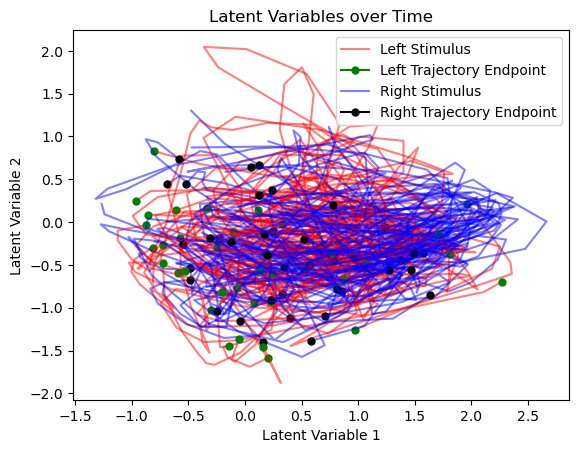

In [ ]:
first = True
first2 = True
correct_left = np.array([])
for i, trial in enumerate(training_trials):
    if ((trial['choice']==1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        # values = StandardScaler().fit_transform(sessionTest.z)
        values = sessionTest.z
        print(i)
        # if first:
        #     fig = px.line_3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], color=["blue"]*len(values), width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], mode='lines', line={'color':"blue"}, opacity=0.5)
            
        # fig.add_scatter3d(x=values[-1:, 0], y=values[-1:, 1], z=values[-1:, 2], marker={'color':'black', 'size':5}) # Marks the end point of the trial
        plt.figure(1)
        if first:
            plt.plot(values[:, 0], values[:, 1], color='blue', alpha=0.5, label="Right Stimulus")
            plt.plot(values[-1:, 0], values[-1:, 1], color='black', marker='.', markersize=10, label='Right Trajectory Endpoint')
            first = False
        else:
            plt.plot(values[:, 0], values[:, 1], color='blue', alpha=0.5)
            plt.plot(values[-1:, 0], values[-1:, 1], color='black', marker='.', markersize=10)
        
        
        # plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 3], color='orange', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 4], color='black', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 5], color='purple', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 6], color='brown', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 7], color='yellow', alpha=0.3)
        
    elif ((trial['choice']==-1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        # values = StandardScaler().fit_transform(sessionTest.z)
        values = sessionTest.z
        # if first:
        #     fig  = px.line_3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], color=["red"]*len(values), width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], mode='lines', line={'color':"red"}, opacity=0.5)
        # fig.add_scatter3d(x=values[-1:, 0], y=values[-1:, 1], z=values[-1:, 2], marker={'color':'green', 'size':5}) # Marks the end point of the trial
        plt.figure(1)
        if first2:
            plt.plot(values[:, 0], values[:, 1], color='red', alpha=0.5, label="Left Stimulus")
            plt.plot(values[-1:, 0], values[-1:, 1], color='green', marker='.', markersize=10, label='Left Trajectory Endpoint')
            first2 = False
        else:
            plt.plot(values[:, 0], values[:, 1], color='red', alpha=0.5)
            plt.plot(values[-1:, 0], values[-1:, 1], color='green', marker='.', markersize=10)
        
        # plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 3], color='orange', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 4], color='black', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 5], color='purple', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 6], color='brown', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 7], color='yellow', alpha=0.3)

# fig.show()
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Variables over Time')
plt.legend()
plt.show()


In [32]:

fig  = px.line_3d(x=session.z[:, 0], y=session.z[:, 1], z=session.z[:, 2], color=["blue"]*len(session.z), width=800, height=800)
fig.show()

In [179]:
first = True
correct_left = []
correct_right = []

for i, trial in enumerate(training_trials):
    if ((trial['choice']==1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        values = StandardScaler().fit_transform(sessionTest.z)
        correct_right.append(values)
        # values = sessionTest.z
        # print(i)
        # if first:
        #     fig = px.line_3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], color=["blue"]*len(values), width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], mode='lines', line={'color':"blue"}, opacity=0.5)
            
        # fig.add_scatter3d(x=values[-1:, 0], y=values[-1:, 1], z=values[-1:, 2], marker={'color':'black', 'size':5}) # Marks the end point of the trial
        # plt.figure(1)
        # plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 3], color='orange', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 4], color='black', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 5], color='purple', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 6], color='brown', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 7], color='yellow', alpha=0.3)
        
    elif ((trial['choice']==-1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        values = StandardScaler().fit_transform(sessionTest.z)
        correct_left.append(values)
        # values = sessionTest.z
        # if first:
        #     fig  = px.line_3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], color=["red"]*len(values), width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], mode='lines', line={'color':"red"}, opacity=0.5)
        # fig.add_scatter3d(x=values[-1:, 0], y=values[-1:, 1], z=values[-1:, 2], marker={'color':'green', 'size':5}) # Marks the end point of the trial
        # plt.figure(2)
        # plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 3], color='orange', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 4], color='black', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 5], color='purple', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 6], color='brown', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 7], color='yellow', alpha=0.3)
# fig.show()
# plt.show()

Trial 0, 	Loss = 576.1233
Trial 1, 	Loss = 612.0981
Trial 3, 	Loss = 4591.6328
Trial 5, 	Loss = 287.2516
Trial 7, 	Loss = 49.0123
Trial 8, 	Loss = 1698.3090


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 10, 	Loss = -14.9371
Trial 11, 	Loss = 416.8846
Trial 12, 	Loss = 175.6126
Trial 13, 	Loss = 382.0946
Trial 14, 	Loss = 298.2271
Trial 15, 	Loss = 601.9788
Trial 17, 	Loss = 3767.6076
Trial 18, 	Loss = 1303.7007


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 19, 	Loss = 370.9787
Trial 20, 	Loss = 1892.2581
Trial 22, 	Loss = 140.2423
Trial 23, 	Loss = 2983.9140
Trial 24, 	Loss = 602.0622
Trial 26, 	Loss = 45.8260
Trial 27, 	Loss = -16.4785
Trial 28, 	Loss = 172.9127


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 29, 	Loss = 1806.0797
Trial 30, 	Loss = 230.3644
Trial 31, 	Loss = 58.1630
Trial 32, 	Loss = 122.0028
Trial 33, 	Loss = 42.4112
Trial 34, 	Loss = 1309.0292
Trial 35, 	Loss = 1394.8285
Trial 36, 	Loss = 589.3958


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 37, 	Loss = 16.1854
Trial 39, 	Loss = 100.6492
Trial 40, 	Loss = -8.4765
Trial 41, 	Loss = 819.5093
Trial 42, 	Loss = 9.4223
Trial 43, 	Loss = 834.6935
Trial 44, 	Loss = 4.3781
Trial 45, 	Loss = 135.9415


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 46, 	Loss = 1302.7107
Trial 49, 	Loss = 346.8347
Trial 50, 	Loss = 1555.3473
Trial 53, 	Loss = -11.0855
Trial 55, 	Loss = 712.6901
Trial 56, 	Loss = 378.1932
Trial 57, 	Loss = 114.0649
Trial 58, 	Loss = 1428.1148


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 61, 	Loss = 93.1421
Trial 62, 	Loss = 365.3865
Trial 63, 	Loss = -13.6002
Trial 64, 	Loss = 1463.5469
Trial 65, 	Loss = 568.7503
Trial 68, 	Loss = 5987.4286
Trial 69, 	Loss = 611.0635
Trial 71, 	Loss = 18.7319


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 72, 	Loss = 623.1129
Trial 73, 	Loss = 1262.9464
Trial 74, 	Loss = -14.6034
Trial 76, 	Loss = 3217.0948
Trial 78, 	Loss = -5.2221
Trial 79, 	Loss = 3525.4038


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 80, 	Loss = 1420.9581
Trial 81, 	Loss = -10.1859
Trial 82, 	Loss = 417.3089
Trial 83, 	Loss = 1106.2608
Trial 84, 	Loss = -13.1347


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 85, 	Loss = -15.1038
Trial 87, 	Loss = 1003.4364
Trial 88, 	Loss = 118.3993
Trial 89, 	Loss = 25.4539
Trial 90, 	Loss = 687.3819
Trial 91, 	Loss = 335.6222
Trial 92, 	Loss = 1415.7077


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 94, 	Loss = 1047.7648
Trial 95, 	Loss = 634.8508
Trial 96, 	Loss = -1.4954
Trial 97, 	Loss = -16.6587
Trial 98, 	Loss = 183.8705
Trial 99, 	Loss = 69.3915
Trial 100, 	Loss = 191.3217
Trial 102, 	Loss = -17.6819


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 103, 	Loss = 155.4481
Trial 104, 	Loss = -15.3257
Trial 105, 	Loss = 167.0078
Trial 106, 	Loss = 1515.7472
Trial 108, 	Loss = 172.1909
Trial 109, 	Loss = 186.0446
Trial 110, 	Loss = 147.9527
Trial 111, 	Loss = -12.2882


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 112, 	Loss = 167.7331
Trial 113, 	Loss = 209.8854
Trial 114, 	Loss = 236.7985
Trial 115, 	Loss = 124.5596
Trial 116, 	Loss = 1.5992


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 118, 	Loss = 1647.0013
Trial 121, 	Loss = 937.7969
Trial 122, 	Loss = 375.7573
Trial 123, 	Loss = 973.1564
Trial 124, 	Loss = 105.9978
Trial 125, 	Loss = -15.2527
Trial 132, 	Loss = 1473.8591
Trial 133, 	Loss = 294.1650


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 134, 	Loss = 307.9043
Trial 136, 	Loss = 300.3801
Trial 137, 	Loss = 231.1452
Trial 139, 	Loss = 130.9098
Trial 141, 	Loss = 121.7435
Trial 142, 	Loss = 4955.7762
Trial 144, 	Loss = 2843.7780
Trial 145, 	Loss = 9510.9969


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 146, 	Loss = -17.6396
Trial 147, 	Loss = 130.8061
Trial 148, 	Loss = 281.8322
Trial 149, 	Loss = -11.3438
Trial 150, 	Loss = 10796.2764
Trial 151, 	Loss = -13.8885
Trial 152, 	Loss = 1683.9386


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



Trial 153, 	Loss = 280.4001
Trial 154, 	Loss = 254.2247
Trial 155, 	Loss = 94.8431
Trial 159, 	Loss = 2236.1444


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:160: UserWarning:

E: loss increased



In [180]:
correct_right_m = np.array(correct_right).mean(axis=0)
correct_left_m = np.array(correct_left).mean(axis=0)

C:\Users\asing\AppData\Local\Temp\ipykernel_6384\2448259924.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: operands could not be broadcast together with shapes (54,3) (55,3) 

In [ ]:
plt.figure(3)
plt.plot(np.arange(0, len(correct_right_m)), correct_right_m[:, 0], color='red')
plt.plot(np.arange(0, len(correct_right_m)), correct_right_m[:, 1], color='green')
plt.plot(np.arange(0, len(correct_right_m)), correct_right_m[:, 2], color='blue')
plt.figure(4)
plt.plot(np.arange(0, len(correct_left_m)), correct_left_m[:, 0], color='red')
plt.plot(np.arange(0, len(correct_left_m)), correct_left_m[:, 1], color='green')
plt.plot(np.arange(0, len(correct_left_m)), correct_left_m[:, 2], color='blue')

In [ ]:
for i, trial in enumerate(testing_trials):
    if ((trial['choice']==1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        values = StandardScaler().fit_transform(sessionTest.z)
        plt.figure(i)
        plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red')
        plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green')
        plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue')

In [ ]:
len(correct_left)

In [ ]:
correct_right

In [120]:
training11_trials = []
training_11_trials = []
training1_1_trials = []
training_1_1_trials = []
testing_trials = []


for i in trials_spikes:
    if ((i["choice"]==1) & (i["feedbackType"]==1)):
        if len(training11_trials) < max_trial_type:
            training11_trials.append(i)
    elif ((i["choice"]==-1) & (i["feedbackType"]==1)):
        if len(training_11_trials) < max_trial_type:
            training_11_trials.append(i)
    elif ((i["choice"]==1) & (i["feedbackType"]==-1)):
        if len(training1_1_trials) < max_trial_type:
            training1_1_trials.append(i)
    elif ((i["choice"]==-1) & (i["feedbackType"]==-1)):
        if len(training_1_1_trials) < max_trial_type:
            training_1_1_trials.append(i)

In [121]:
session11 = Session(bin_size)
# y = pd.read_csv("neural_data.csv")
# session.add_trial(0, y=y)
for i, trial in enumerate(training11_trials):
    # print(trial['spikes_df'].T.shape)
    session11.add_trial(i, y=trial['spikes_df'].T)
    
kernel = RBF(scale=1, lengthscale=0.2)

session11, params11 = vi.fit(session11, n_factors=3, kernel=kernel, seed=120, max_iter=15, trial_length=20, GPFA=True)

Initializing
Initialized


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:270: UserWarning:

M: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



EM Iteration 1, 	Loss = -10.8198, 	M step: 1.35s, 	E step: 1.41s


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:270: UserWarning:

M: loss increased



EM Iteration 2, 	Loss = 38.1110, 	M step: 0.14s, 	E step: 0.53s
Inferring


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:408: UserWarning:

EM: loss increased



Trial 0, 	Loss = -13.2056
Trial 1, 	Loss = -14.4948
Trial 2, 	Loss = -12.8458
Trial 3, 	Loss = -14.6396
Trial 4, 	Loss = -13.7977


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Finished


In [122]:
session_11 = Session(bin_size)
# y = pd.read_csv("neural_data.csv")
# session.add_trial(0, y=y)
for i, trial in enumerate(training_11_trials):
    # print(trial['spikes_df'].T.shape)
    session_11.add_trial(i, y=trial['spikes_df'].T)


session_11, params_11 = vi.fit(session_11, n_factors=3, kernel=kernel, seed=120, max_iter=15, trial_length=20, GPFA=True)

Initializing
Initialized


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:270: UserWarning:

M: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



EM Iteration 1, 	Loss = -10.5058, 	M step: 0.17s, 	E step: 0.56s
EM Iteration 2, 	Loss = -11.4575, 	M step: 0.15s, 	E step: 0.51s
EM Iteration 3, 	Loss = 32.3940, 	M step: 0.15s, 	E step: 0.51s
Inferring
Trial 0, 	Loss = -12.6580
Trial 1, 	Loss = -13.2579
Trial 2, 	Loss = 61.6999
Trial 3, 	Loss = 1916.6706
Trial 4, 	Loss = -14.1509


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:408: UserWarning:

EM: loss increased



Finished


In [118]:
from einops import rearrange

In [123]:
z11 = rearrange(session11.z, '(trials time) lat -> trials time lat', time=training11_trials[0]['spikes_df'].shape[1])
z_11 = rearrange(session_11.z, '(trials time) lat -> trials time lat', time=training_11_trials[0]['spikes_df'].shape[1])

In [125]:
z11[0, :, 0]

DeviceArray([-1.34588199, -1.37119594, -1.37378734, -1.35298422,
             -1.30920565, -1.2436446 , -1.15895679, -1.05836696,
             -0.9459566 , -0.82624404, -0.70402469, -0.58410963,
             -0.47100958, -0.36878748, -0.28077105, -0.2095553 ,
             -0.1568235 , -0.12334075, -0.10906999, -0.11323028,
             -0.13434314, -0.17049764, -0.21937748, -0.27848201,
             -0.34516858, -0.41679652, -0.49077007, -0.56454329,
             -0.63569492, -0.70185336, -0.76080904, -0.81039985,
             -0.84858031, -0.87348612, -0.88343386, -0.8770307 ,
             -0.8532175 , -0.8114026 , -0.75149443, -0.67399064,
             -0.58003242, -0.47134913, -0.35034162, -0.21988356,
             -0.08336193,  0.05576245,  0.19367974,  0.32651755,
              0.45098826,  0.56392342,  0.66266866,  0.74524733,
              0.81030404,  0.85721116,  0.88600795], dtype=float64)

In [124]:
fig = px.line_3d(x=z11[0, :, 0], y=z11[0, :, 1], z=z11[0, :, 2], color=["blue"]*training_11_trials[0]['spikes_df'].shape[1], width=800, height=800)

for trial in z11:
     fig.add_scatter3d(x=trial[:, 0], y=trial[:, 1], z=trial[:, 2], mode='lines', line={'color':"blue"}, opacity=0.5)

for trial in z_11:
     fig.add_scatter3d(x=trial[:, 0], y=trial[:, 1], z=trial[:, 2], mode='lines', line={'color':"red"}, opacity=0.5)

fig.show()

In [267]:
z11.shape

(60, 55, 3)

In [268]:
len(z11[0, :, 2])

55

In [269]:
print('hi')

hi


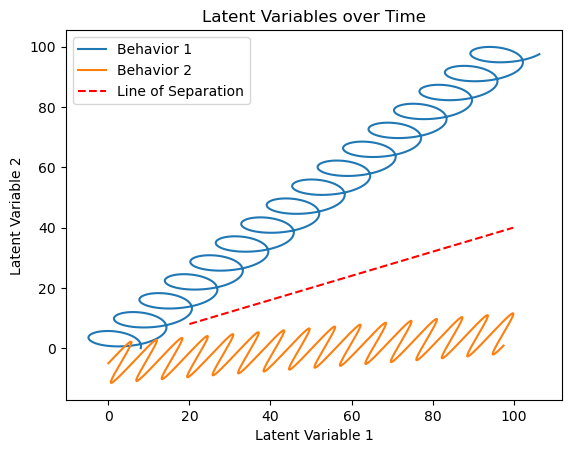

In [92]:
x = np.arange(0, 100, 0.1)
y = 4 *np.sin(x) + x 
y2 = 7 *np.sin(x) + 0.1*x - 5
y3 = 8*np.cos(x) + 1*x
y4 = 0.4 * x

plt.plot(y3, y, label='Behavior 1')
plt.plot(y, y2, label='Behavior 2')
plt.plot(x[int(len(x)*0.2):], y4[int(len(x)*0.2):], label='Line of Separation', color='red', linestyle='--')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Variables over Time')
plt.legend()
plt.show()

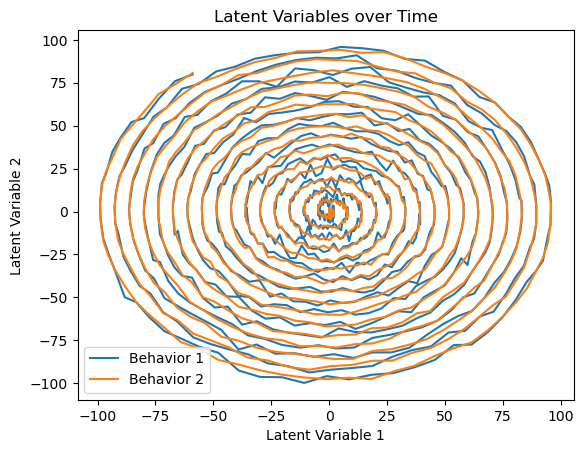

In [115]:
x = np.arange(0, 100, 0.1)
y = np.sin(x)*x
y2 = np.cos(x)*x + np.random.normal(0, 2, size=len(x))
y3 = np.cos(x)*x + np.random.normal(0, 1, size=len(x))
y4 = 0.4 * x

plt.plot(y, y2, label='Behavior 1')
plt.plot(y, y3, label='Behavior 2')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Variables over Time')
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.legend()
plt.show()